<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller: Identificando  Burger Master con MMG

El Burger Master es un evento creado en el 2016 por el *influencer* Tulio Zuluaga, más conocido en redes como Tulio recomienda, el cual busca que por una semana las hamburgueserías de cada ciudad ofrezcan su mejor producto a un precio reducido. 

El evento ha venido creciendo y en el 2022 se extendió por 21 ciudades de Colombia para las cuales se estimó que se vendieron más de dos millones de hamburguesas. El objetivo del presente caso-taller  es identificar los puntos calientes de hamburgueserías  que compitieron en  la ciudad de Bogotá aplicando el Modelo de Mezclas Gaussianas.

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo

### 1. Carga de datos  

En la carpeta `data` se encuentra el archivo `burger_master.xlsx` para la ciudad de Bogotá, cargue estos datos en su *cuaderno* y reporte brevemente el contenido de la base.

In [3]:
# Utilice este espacio para escribir el código.
import pandas as pd
import seaborn as sns
burger_master = pd.read_excel("data/burger_master.xlsx")

In [4]:
burger_master.head()

,Restaurante,Dirección,Descripción,Latitud,Longitud
0,MAIKKI,Cra 75 # 24D – 48,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.668833,-74.116828
1,MAIKKI,Calle 119 # 11A – 24,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.698395,-74.036585
2,MAIKKI,Cra 47A # 98 – 47,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.686401,-74.060144
3,FRENCHEESE,Calle 51 #22-55,"<p>Presentamos «La French Master», inspirada e...",4.639514,-74.073545
4,FRENCHEESE,Calle 80 #14-41,"<p>Presentamos «La French Master», inspirada e...",4.666147,-74.056758


In [7]:
burger_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Restaurante  137 non-null    object 
 1   Dirección    137 non-null    object 
 2   Descripción  137 non-null    object 
 3   Latitud      137 non-null    float64
 4   Longitud     137 non-null    float64
dtypes: float64(2), object(3)
memory usage: 5.5+ KB


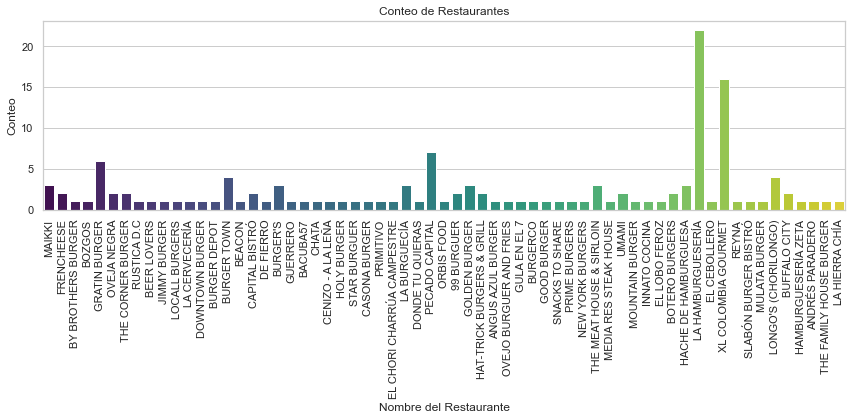

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

## Se acomoda el estilo y el tamaño del gráfico
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6)) 
sns.countplot(x='Restaurante', data=burger_master, palette='viridis')

## Se rotan los nombres de los restaurantes en el eje x
plt.xticks(rotation=90)

plt.xlabel('Nombre del Restaurante')
plt.ylabel('Conteo')
plt.title('Conteo de Restaurantes')

# Muestra el gráfico
plt.tight_layout()
plt.show()

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

### 2.  Visualizando los datos

Visualice la ubicación de cada restaurante en un mapa interactivo. Añada un marcador para cada restaurante y la posibilidad de encontrar la descripción de la hamburguesa ofrecida en un pop-up. (Note que la columna Descripción contiene otra información adicional).

In [8]:
# Utilice este espacio para escribir el código.
import folium
from folium import Popup

latitud_inicial = burger_master['Latitud'].iloc[0]
longitud_inicial = burger_master['Longitud'].iloc[0]

## Se crea un mapa con las coordenadas iniciales
mapa = folium.Map(location=[latitud_inicial, longitud_inicial], zoom_start=12)

for index, row in burger_master.iterrows():
    restaurante = row['Restaurante']
    latitud = row['Latitud']
    longitud = row['Longitud']
    descripcion = row['Descripción']
    
    ## Se hace un marcador en las coordenadas del restaurante y agrega un pop-up con la descripción
    marcador = folium.Marker(location=[latitud, longitud], popup=Popup(restaurante + ': ' + descripcion, parse_html=True))
    marcador.add_to(mapa)

mapa



c:\Users\Felipe\anaconda3\envs\Financiero\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

### 3.  Análisis de puntos calientes

Aplique el modelo de Mezclas Gaussianas para buscar clusters de restaurantes en Bogotá, mencione qué estructura de covarianza usó y explique por qué. Escoja el número óptimo de componentes, explicando el procedimiento y justificando su elección.

In [11]:
# Utilice este espacio para escribir el código.

import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

features = burger_master[['Latitud', 'Longitud']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)



In [13]:
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=3).fit(scaled_features)
          for n in n_components]

plt.plot(n_components, [-m.score(scaled_features) for m in models], label='Log-Verosimilitud (neg)')
plt.xlabel('Número de componentes')

AttributeError: 'NoneType' object has no attribute 'split'

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

#### 3.1. Visualización de los resultados

Visualice las densidades estimadas por el  mejor modelo estimado en la sección anterior usando un mapa de calor interactivo, discuta los resultados.

In [8]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

### 4. Comparación con KDE

Estime ahora las densidades usando KDE bivariado de la librería `statsmodels` con el anchos de banda dado por `cv_ml`. Muestre los resultados usando un mapa interactivo. Compare los resultados obtenidos por el "mejor" modelo encontrado via MMG. 

In [9]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)